In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import dask.dataframe as dd # data processing
import matplotlib.pyplot as plt # data visualisation
import seaborn as sns # data visualisation
import dataprep # data pre-processing
import category_encoders 

sns.set()
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
path = 'Data/train.csv' # training data path
data = pd.read_csv(path) # read data

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# pd.set_option('display.max_columns', 100)
data.head(10) # display top 10 rows

,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,...,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,target
0,2,H,224,0,4300,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
1,4,H,7,53,4448,B,1.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
2,5,H,116,3,3464,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
3,7,H,240,300,3200,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,RCC,0
4,8,R,72,261,2000,N,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,BRANCH,1
5,14,R,4,4,4422,C,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
6,16,H,60,132,40000,C,1.0,1.0,False,False,...,0,1,0,999999996,400,400,9996,76,IAPS,1
7,20,R,13,75,3600,B,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,IAPS,0
8,21,R,17,16,2296,N,1.0,1.0,False,False,...,0,97,997,999999997,400,997,9996,90,MOBILE,1
9,22,R,24,72,450,N,0.0,0.0,False,False,...,98,98,998,999999998,998,998,9998,9998,BRANCH,0


In [4]:
# number of rows and columns in dataset
rows = data.shape[0]
columns = data.shape[1]
print("Data has {} rows, {} columns".format(rows, columns))

Data has 145231 rows, 1934 columns


# DATA PREPROCESSING

## Handle Nulls

In [5]:
# number of nulls in dataset
nulls = (data.isna().sum()/rows)*100

# columns with more than 25% nulls
columns_to_remove = []

# columns with nulls
null_columns = []

for i in nulls.index:
    if(nulls[i] >= 25):
        columns_to_remove.append(i)
    elif(nulls[i]>0):
        null_columns.append(i)


In [6]:
# drop columns with more than 25% of nulls
data = data.drop(columns_to_remove, axis = 1)

print("Columns remaining are {}".format(data.shape[1]))

Columns remaining are 1910


In [7]:
# dropping rows with nulls (atmost 0.68% values are null in a null_columns)
data = data.dropna().reset_index(drop = True)

## Clean Data

In [8]:
# categorical variables
cat_vars = []

for i in data.columns:
    if(data[i].dtype == 'object'):
        cat_vars.append(i)

In [9]:
# columns to drop (with same value across the dataset)
to_drop = ["ID", "VAR_0236", "VAR_0239", "VAR_0075", "VAR_0204", "VAR_0217"]

for i in cat_vars:
    if len(data[i].value_counts().index) == 1:
        to_drop.append(i)

In [10]:
data = data.drop(to_drop, axis = 1)

## Split into Train & Validation parts

In [11]:
from sklearn.model_selection import train_test_split

# dependent variables
X = data.drop(['target'], axis = 1)
# independent variable
y = data['target']

# split data into train and validation part
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5)

## Handle Categorical variables

In [12]:
# encode categorical variable using LeaveOneOutEncoding technique
from category_encoders import LeaveOneOutEncoder

# columns to encode
encode_cols = []

# binary categorical columns
bin_cat_cols = []

for i in X_train.columns:
#     categorical columns remaining
    if(i in cat_vars and not (i in to_drop)):
        if(len(X_train[i].value_counts().index)>2):
#             non-binary valued columns
            encode_cols.append(i)
        else:
#             binary valued columns
            bin_cat_cols.append(i)

# intialise encoder
encoder = LeaveOneOutEncoder(cols = encode_cols)

In [13]:
# fit and encode data
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)

In [14]:
# encode binary categorical variables
bin_code = {True : 1, False : 0}

X_train_encoded = X_train_encoded.replace(bin_code)
X_val_encoded = X_val_encoded.replace(bin_code)

X_train_encoded['VAR_0466'] = X_train_encoded['VAR_0466'].replace({'I':1, "-1":0})
X_val_encoded['VAR_0466'] = X_val_encoded['VAR_0466'].replace({'I':1, "-1":0})

In [15]:
# remove columns where min value is same as threshold percentile value
columns_to_remove = []

# threshold
threshold_quantile = 0.75
for i in data.columns:
    if(i != 'target' and min(X_train_encoded[i]) == X_train_encoded[i].quantile(threshold_quantile)):
        columns_to_remove.append(i)

print("Columns with same minimum and {}th percentile are {}".format(threshold_quantile, len(columns_to_remove)))

Columns with same minimum and 0.75th percentile are 519


In [16]:
X_train_encoded = X_train_encoded.drop(columns_to_remove, axis = 1)
X_val_encoded = X_val_encoded.drop(columns_to_remove, axis = 1)

## Handle Outliers

In [17]:
def handleOutliers(data, to_return = False):
    ''' 
    Removes outliers from each column and reports the data loss
    
    Args:
        data (DataFrame) : The DataFrame to remove outliers from
        to_return (bool) :  - Default value False
                            - Whether to return the DataFrame after removing outliers
    
    Returns:
        DataFrame : data free from outliers
    '''
#     calculate first quantile
    Q1 = data.quantile(0.25)
#     calculate third quantile
    Q3 = data.quantile(0.75)
#     calculate inter quartile range
    IQR1 = Q3-Q1

#     initialise data w/o outliers (drop outliers)
    data_c = data[~((data < (Q1-1.5*IQR1))|(data > (Q3+1.5*IQR1))).any(axis = 1)] 
    
#     report data loss
    print('Data loss is {}%'.format(((len(data) - len(data_c))/len(data))*100))
    
    if(to_return):
        return data_c.reset_index(drop = True)

In [18]:
handleOutliers(X_train_encoded)

Data loss is 100.0%


### Considering each feature individually for outlier analysis

In [19]:
def countOutliers(data, column):
    ''' 
    Calculates the number of outliers in given column
    
    Args:
        data (DataFrame) : The dataset in form of Pandas DataFrame
        column (string) : The column to report number of outliers in
    
    Returns:
        int : percentage of outliers in column
    '''
#     calculate first quantile
    Q1 = data[column].quantile(0.25)
#     calculate third quantile
    Q3 = data[column].quantile(0.75)
#     calculate inter quartile range
    IQR1 = Q3-Q1
    
#     % of outliers in the column
    return (len(data[((data[column] < (Q1-1.5*IQR1))|(data[column] > (Q3+1.5*IQR1)))])/len(data))*100

In [20]:
# percentage of outliers in each column
outliers = {}

for column in X_train_encoded.columns:
    outliers[column] = countOutliers(X_train_encoded, column)

In [21]:
# sort in decreasing order
outliers = dict(sorted(outliers.items(), key=lambda item: item[1], reverse = True))

# threshold percentage of outliers
threshold_outliers = 0

# remove columns with more than threshold
to_drop_outliers = []

for i in outliers:
    if(outliers[i] <= threshold_outliers):
        break
    elif(i != 'target'):
        to_drop_outliers.append(i)

print("Columns with more than {}% of values as Outliers are {}".format(threshold_outliers, len(to_drop_outliers)))

Columns with more than 0% of values as Outliers are 927


In [22]:
# drop columns with oultiers
X_train = X_train_encoded.drop(to_drop_outliers, axis = 1)

In [23]:
# check presence of outliers
handleOutliers(X_train)

Data loss is 0.0%


In [24]:
X_val = X_val_encoded.drop(to_drop_outliers, axis = 1)

## Scale Value

In [25]:
from sklearn.preprocessing import StandardScaler

# intialise StandardScaler
scaler_PCA = StandardScaler()

# Scale training data
X_train_scaled = scaler_PCA.fit_transform(X_train)

# Scale validation data
X_val_scaled = scaler_PCA.transform(X_val)

## Dimensionality Reduction

### Hyperparameters : 
#1 reduceDim : threshold_PCA

In [26]:
scores = {}

In [27]:
from sklearn.decomposition import PCA

def reduceDim(X_train, threshold_PCA):
    ''' 
    Calculates number of Principal Components to retain 
    atleast "threshold" variance
    
    Args:
        X_train (DataFrame) : The training dataset in form of Pandas DataFrame
        threshold_PCA (float) : Minimum value of variance to retain
    
    Returns:
        PCA object : The PCA instance to transform validation and test data
        DataFrame : The transformed training dataset
    '''
#     intialise PCA
    pca = PCA(n_components = threshold_PCA)
#     fit and transform training data
    X_train_PCA = pca.fit_transform(X_train)
    
#     print info
    print("Number of columns retained : {} \nNumber of columns in original dataset : {}"
          .format(X_train_PCA.shape[1], X_train.shape[1]))
    
    return (pca, X_train_PCA)

In [28]:
threshold_PCA = 0.99
pca, X_train_PCA = reduceDim(X_train_scaled, threshold_PCA)

Number of columns retained : 119 
Number of columns in original dataset : 445


In [29]:
# apply PCA to validation data
X_val_PCA = pca.transform(X_val_scaled)

## Handle Class Imbalance

In [30]:
from imblearn.over_sampling import SMOTE #to over sample minority class (outcome = 1)
from imblearn.under_sampling import RandomUnderSampler #to under sample majority class (outcome = 0)

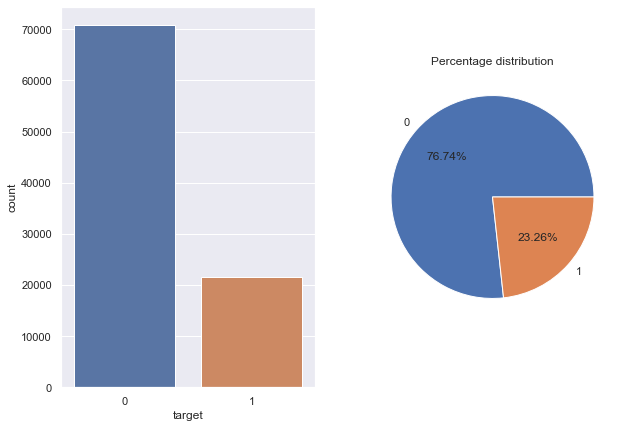

In [31]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 7)) # set up plot 

# visualise distribution in Ytrain

sns.countplot(x = y_train, ax = ax[0]) # plot bar plot

# plot a pie chart
ax[1].pie(x = y_train.value_counts().values, labels = y_train.value_counts().index, autopct = "%.2f%%")
ax[1].set_title("Percentage distribution") # set title

# display plots
plt.show()

In [32]:
# apply SMOTE to balance target variable
smote = SMOTE(sampling_strategy = 1, k_neighbors = 5, random_state = 9)
# undersample Majority class (target = 1)
under = RandomUnderSampler(sampling_strategy = 1, random_state = 9) 

X_train_bal, y_train_bal = smote.fit_resample(X_train_PCA, y_train) #apply oversampling
X_train_bal, y_train_bal = under.fit_resample(X_train_bal, y_train_bal) #apply undersampling

## Correct Skewness

In [33]:
def removeSkew(X, skew_index):
    ''' 
    Removes columns with skew distribution using "skew_index" array
    
    Args:
        X (Numpy Array) : The dataset to remove skew columns from
        skew_index (Numpy Array) : List of columns to remove from "X"
    
    Returns:
        Numpy Array : The data without skew columns
    '''
    return np.array(pd.DataFrame(X).drop(skew_index, axis=1))

In [34]:
# conver NP array to pandas DF
skew = pd.DataFrame(X_train_bal).skew()

# columns with asymmetrical distribution
skew_index = np.array(skew[~((skew>=-0.5) & (skew <= 0.5))].index)

print("Number of columns with skew distribution : {}".format(len(skew_index)))

# remove skewed columns
X_train_normal = removeSkew(X_train_bal, skew_index)
X_val_normal = removeSkew(X_val_PCA, skew_index)

Number of columns with skew distribution : 14


In [35]:
# intialise StandardScaler
scaler = StandardScaler()

# Scale training data
X_train_normal_scaled = scaler.fit_transform(X_train_normal)

# Scale validation data
X_val_normal_scaled = scaler.transform(X_val_normal)

# Machine Learning

In [36]:
from sklearn.metrics import roc_auc_score

def getScore(clf, X, y):
    ''' 
    Calculates roc_auc_score for the given data using "clf"
    
    Args:
        clf : The instance for classification algorithm
        X (Numpy Array) : The dependent variables
        y (Numpy Array) : The independent variables
    
    Returns:
        float : The score calculated
    '''
    return roc_auc_score(y, clf.predict(X))

In [37]:
def printReport(clf, X_train, y_train, X_val, y_val):
    ''' 
    reports roc_auc_score for the training and validation data using "clf"
    
    Args:
        clf : The instance for classification algorithm
        X_train (Numpy Array) : The dependent variables for training
        y_train (Numpy Array) : The independent variables for training
        X_val (Numpy Array) : The dependent variables for validation
        y_val (Numpy Array) : The independent variables for validation
    
    Returns:
        (float, float) : Training & Validation score
    '''
#     find scores
    train_score = getScore(clf, X_train, y_train)
    val_score = getScore(clf, X_val, y_val)
    
    print("Training Score : {}\nValidation Score: {}".format(train_score, val_score))
    
    return (train_score, val_score)

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV #import GridSearchCV

params = {'C' : [0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]} # values of C parameter in LR to try for

clf_lr = GridSearchCV(LogisticRegression(), params) # Logistic Regression

clf_lr.fit(X_train_normal_scaled, y_train_bal) # train LR model

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005,
                               0.01, 0.03, 0.05, 0.1, 0.3, 0.5]})

In [190]:
# report scores
lr_scores = printReport(clf_lr, X_train_normal_scaled, y_train_bal, X_val_normal_scaled, y_val)
scores[threshold_PCA] = [{"lr":lr_scores}]

Training Score : 0.6610864197530864
Validation Score: 0.6376611530459602


In [199]:
from lightgbm import LGBMClassifier

# intialise LGBM algorithm
clf_lgbm = LGBMClassifier()

# fit on training data
clf_lgbm.fit(X_train_normal_scaled, y_train_bal)

LGBMClassifier()

In [200]:
# report scores
lgbm_scores = printReport(clf_lgbm, X_train_normal_scaled, y_train_bal, X_val_normal_scaled, y_val)
scores[threshold_PCA].append({"lgbm":lgbm_scores})

Training Score : 0.7900529100529101
Validation Score: 0.6078303354453595


In [197]:
from sklearn.naive_bayes import GaussianNB

# intialise Gaussian Naive Bayes
clf_nb = GaussianNB()

# fit 
clf_nb.fit(X_train_normal_scaled, y_train_bal)

GaussianNB()

In [198]:
# report scores
nb_scores = printReport(clf_nb, X_train_normal_scaled, y_train_bal, X_val_normal_scaled, y_val)
scores[threshold_PCA].append({"nb":nb_scores})

Training Score : 0.695358024691358
Validation Score: 0.5403479882018833


In [191]:
from sklearn.linear_model import SGDClassifier

# params to try for SGD
params_SGD = {
    "alpha" : [0.01, 0.03, 0.05, 0.08, 0.001, 0.003, 0.005, 0.007, 0.0001, 0.0003, 0.0005, 0.0007]
}

# intialise Stochastic Gradient Descent Classifier
clf_SGD = GridSearchCV(SGDClassifier(max_iter = 20000, early_stopping=True), params_SGD)

# fit
clf_SGD.fit(X_train_normal_scaled, y_train_bal)

GridSearchCV(estimator=SGDClassifier(early_stopping=True, max_iter=20000),
             param_grid={'alpha': [0.01, 0.03, 0.05, 0.08, 0.001, 0.003, 0.005,
                                   0.007, 0.0001, 0.0003, 0.0005, 0.0007]})

In [192]:
# report scores
sgd_scores = printReport(clf_SGD, X_train_normal_scaled, y_train_bal, X_val_normal_scaled, y_val)
scores[threshold_PCA].append({"sgd":sgd_scores})

Training Score : 0.6596543209876544
Validation Score: 0.6374191852651065


In [201]:
# data to plot
vals_plot_alg = []

# 
for i in scores:
    for j in scores[i]:
        for k in j:
            vals_plot_alg.append([i, k, j[k][1]])

In [202]:
scores_df = pd.DataFrame(vals_plot_alg, columns=['threshold_PCA', 'Algorithm', 'val_score'])

scores_df.to_csv("Algo_report.csv", index = False)

[]

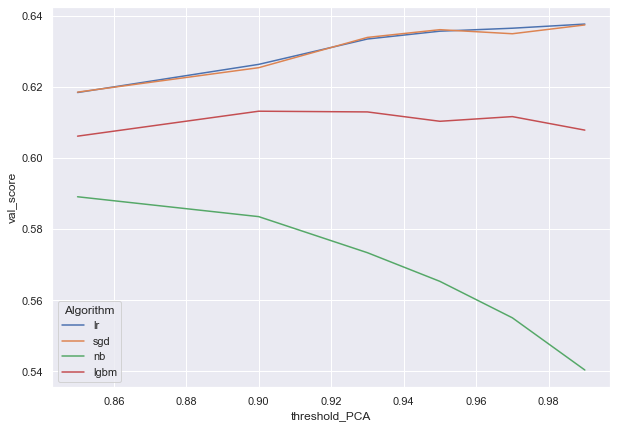

In [203]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 7)) # set up plot 
sns.lineplot(x = 'threshold_PCA', y = 'val_score', hue = 'Algorithm', data = scores_df, ax = ax)
plt.plot()

### Base Model : SGDClassifier
#### Val Score  = 0.637

# Deep Learning

In [60]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
model = Sequential([Dense(256, activation = 'relu', input_dim = X_train_normal_scaled.shape[1]),
                    Dropout(0.8),
           Dense(256, activation = 'relu'),
           Dense(512, activation = 'relu'),
           Dense(512, activation = 'relu'),
                    Dropout(0.8),
#            Dense(1024, activation = 'relu'),
#            Dense(1024, activation = 'relu'),
           Dense(1024, activation = 'relu'),
           Dense(1024, activation = 'relu'),
                    Dropout(0.8),
           Dense(512, activation = 'relu'),
           Dense(512, activation = 'relu'),
           Dense(256, activation = 'relu'),
           Dense(256, activation = 'relu'),
                    Dropout(0.8),
           Dense(1, activation = 'sigmoid')
            ]
          )

model.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = 'AUC')

In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 256)               27136     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                                                 
 dense_35 (Dense)            (None, 512)               131584    
                                                                 
 dense_36 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 1024)             

In [58]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_auc',
                       patience = 3,
                       verbose = 1,
                       factor = 0.5,
                       min_lr=0.00001)
model_checkpoint_callback = ModelCheckpoint(
    filepath='0002model_nn',
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True)


In [62]:
model.fit(X_train_normal_scaled, y_train_bal, epochs = 30, validation_data = (X_val_normal_scaled, y_val),
         callbacks = [learning_rate_reduction, model_checkpoint_callback])

Epoch 1/25
4430/4430 [==============================] - 157s 35ms/step - loss: 0.6423 - auc: 0.6853 - val_loss: 0.9891 - val_auc: 0.6771 - lr: 0.0010
Epoch 2/25
4430/4430 [==============================] - 154s 35ms/step - loss: 0.6052 - auc: 0.7395 - val_loss: 1.0769 - val_auc: 0.6831 - lr: 0.0010
Epoch 3/25
4430/4430 [==============================] - ETA: 0s - loss: 0.5918 - auc: 0.7552
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4430/4430 [==============================] - 155s 35ms/step - loss: 0.5918 - auc: 0.7552 - val_loss: 0.9702 - val_auc: 0.6933 - lr: 0.0010
Epoch 4/25
4430/4430 [==============================] - 159s 36ms/step - loss: 0.5721 - auc: 0.7749 - val_loss: 1.1562 - val_auc: 0.6936 - lr: 5.0000e-04
Epoch 5/25
4430/4430 [==============================] - ETA: 0s - loss: 0.5641 - auc: 0.7836
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
4430/4430 [==============================] - 152s 34ms/step -

In [63]:
printReport(model, X_train_normal_scaled, y_train_bal, X_val_normal_scaled, y_val)

Training Score : 0.840030790627362
Validation Score: 0.6933259863764278


(0.840030790627362, 0.6933259863764278)